# Avellaneda and Stoikov model calibration

AvellanedaStoikov parameter calibration for gamma ray HFT trading bot

In [8]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

## Introduction

Gamma ray HFT trading bot uses the finite horizon Avellaneda and Stoikov model with the following formulation:

**assmue order arrial rate**
$$\lambda^a(\delta)=\lambda^b(\delta)=Ae^{-k\delta}$$

**reservation price**

$$r(s,t)=s-q\gamma\sigma^2(T-t)$$

**spread**
$$\delta=\delta^a+\delta^b=\gamma\sigma^2(T-t)+\frac{2}{\gamma}\ln(1+\frac{\gamma}{k})$$

**bid price**
$$r^b(s,q,t)=r(s,t)-\frac{1}{2}\delta$$

**ask price**
$$r^a(s,q,t)=r(s,t)+\frac{1}{2}\delta$$

**The following contents in this notebook will calibrate the following parameters**:

1. sigma
2. k
3. gamma

For more information you can refer to the original [paper](https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book). It is worth noting that calibration of the above parameters are non-trivial, they are active research fields with various on going studies. This notebook only provide one (simple) method for calibrating the model.

## Playground

This is a implementation of the model in python, you can plug in different parameters and see the outputs of the model to get a tangible feeling of the model

In [10]:
T = 1.0
t = 0.0
dt = T - t
gamma = 0.1
sigma = 0.02
k = 0.1159
q = 0
s = 9500

r = s - q * gamma * sigma**2 * dt

# Reserve spread
r_spread = gamma * sigma**2 * dt +2 / gamma * math.log(1+gamma/k)    

# optimal quotes
ra = r + r_spread/2
rb = r - r_spread/2
print("ask quote: ", ra)
print("bid quote", rb)

ask quote:  9506.220895871751
bid quote 9493.779104128249


## Trading data

For illustration purpose, we will only one day's XBTUSD quoting data and trading data. In practise you should use a much longer sample of historical prices and trades. You can get all historical data here: https://public.bitmex.com/

In [2]:
quotes = pd.read_csv("./data/quotes.csv")
trades = pd.read_csv("./data/trades.csv")
quotes.loc[:, 'timestamp'] = pd.to_datetime(quotes.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")
trades.loc[:, 'timestamp'] = pd.to_datetime(trades.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")

In [3]:
xbt_quotes = quotes[quotes['symbol'] == 'XBTUSD']
xbt_trades = trades[trades['symbol'] == 'XBTUSD']

In [4]:
# calculate mid price by averaging best bid and best ask
xbt_quotes.loc[:, 'midPrice'] = (xbt_quotes.bidPrice + xbt_quotes.askPrice) / 2

/Users/Ted/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Ted/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


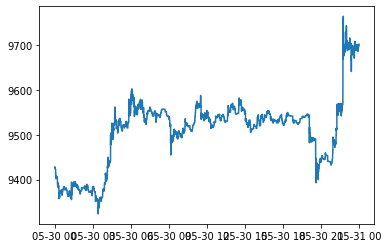

In [5]:
# reset the index to timestamp and plot the price change for the day
Xt = xbt_quotes.set_index('timestamp').midPrice
plt.plot(Xt)

## Parameter estimation: sigma

In this chapter we calibrate the model parameter sigma, which is measures the volitility of an assumed brownian motion. We use the first solution proposed here:
https://alexioannides.com/2019/01/18/stochastic-process-calibration-using-bayesian-inference-probabilistic-programs/

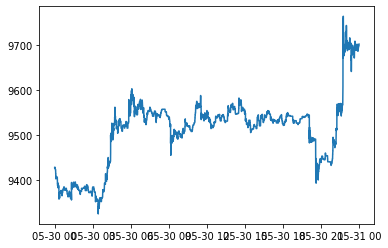

In [11]:
# resample prices with 1 second fixed interval
resample = Xt.resample('1S').last().bfill()
plt.plot(resample)

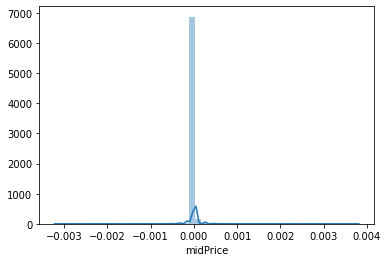

In [12]:
log_norm = np.log(resample).diff(1).dropna()
sns.distplot(log_norm)

In [13]:
# calculate deviation
sigma = log_norm.std() * np.sqrt(3600*24)
print(sigma)

0.020185781716491456


## Parameter esitmation: k

Parameter k measures the probability of an order being executed at a given tick, here will estimate k by counting trades in **n** samples with each sample being a 10 seconds time period. For more information you can read Joaquin FERNANDEZ TAPIA's PhD thesis: 
[Modeling, optimization and estimation for the on-line control of trading algorithms in limit-order markets](https://www.researchgate.net/publication/284900784_Modeling_optimization_and_estimation_for_the_on-line_control_of_trading_algorithms_in_limit-order_markets) Chapter 4

![captured liquidity](./footage/captured_liquidity.png)

### Average volume quantity

We will find the average marketable order size

In [14]:
# we use the median quantity as the average volume quantity
xbt_trades_filtered = xbt_trades[xbt_trades['size'] > 25] # filter out small trades
xbt_trades_filtered['size'].describe()

count    3.252920e+05
mean     4.417609e+03
std      1.765609e+04
min      2.600000e+01
25%      9.700000e+01
50%      5.000000e+02
75%      2.500000e+03
max      1.680485e+06
Name: size, dtype: float64

So the average volume quantity is 50 percitile: 500

### Estimate trade intensity

In [15]:
# rounding util functions

def round_up(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return x + tick - remainder

def round_down(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return math.floor(x / tick) * tick

In [18]:
# TODO: this part is really slow, could be more efficient(pre-allocate memory) and use parallel processing to speed things up

# sample time window in seconds
dT = 10
# number of samples
n = 0
# initial timestamp
T0 = xbt_quotes.iloc[0, :].timestamp
# end timestamp
T_final = xbt_quotes.iloc[-1, :].timestamp
# min tick size
tick = 0.5
# measured spread range
r = 40 # 40*0.5=20

T_start = T0
T_end = T_start + pd.Timedelta(seconds=dT)

ask_side_hits = np.array([])
bid_side_hits = np.array([])

while T_end < T_final:
    
    print("Processing timestamp: ", T_start)
    # reference price S(t)
    St = xbt_quotes[xbt_quotes.timestamp >= T_start].iloc[0, :].midPrice
    # ask side
    St_ask = round_down(St, tick)
    # get marketable bids
    criteria_1 = (xbt_trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (xbt_trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (xbt_trades_filtered.side == 'Buy') # side is "Buy"
    criteria_4 = (xbt_trades_filtered.price > St_ask) # price must be higher than St_ask
    criteria_5 = (xbt_trades_filtered.price <= St_ask + (r * tick)) # price must be lower than the measured spread range
    m_bids = xbt_trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]
    
    if len(m_bids.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_bids.price.unique(), St_ask), tick)
        ask_side_hits = np.hstack([ask_side_hits, hits])
    
    # bid side
    St_bid = round_up(St, tick)
    # get marketable asks
    criteria_1 = (xbt_trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (xbt_trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (xbt_trades_filtered.side == 'Sell') # side is "Sell"
    criteria_4 = (xbt_trades_filtered.price < St_bid) # price must be lower than St_bid
    criteria_5 = (xbt_trades_filtered.price >= St_bid - (r * tick)) # price must be higher than the measured spread range
    m_asks = xbt_trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]
    
    if len(m_asks.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_asks.price.unique(), St_bid), -tick)
        bid_side_hits = np.hstack([bid_side_hits, hits])
        
    T_start = T_start + pd.Timedelta(seconds=dT)
    T_end = T_end + pd.Timedelta(seconds=dT)
    n = n + 1
    # break

print('done with {0} samples'.format(n))

Processing timestamp:  2020-05-30 00:00:02.757106
done with 1 samples


In [183]:
unique, counts = np.unique(ask_side_hits, return_counts=True)
ask_side_hits_agg = np.asarray((unique, counts)).T
unique, counts = np.unique(bid_side_hits, return_counts=True)
bid_side_hits_agg = np.asarray((unique, counts)).T
df_ask = pd.DataFrame(ask_side_hits_agg, columns=['tick', 'hits'])
df_bid = pd.DataFrame(bid_side_hits_agg, columns=['tick', 'hits'])
df_ask = df_ask.div([1, n])
df_ask = df_ask.rename(columns = {'hits': 'intensity'})
df_bid = df_bid.div([1, n])
df_bid = df_bid.rename(columns = {'hits': 'intensity'})

In [184]:
## you might want to save your hard calculated results
# df_ask.to_csv('ask_side_intensity.csv')
# df_bid.to_csv('bid_side_intensity.csv')

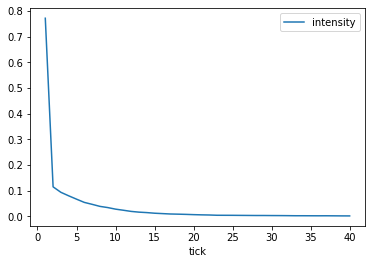

In [188]:
df_ask.plot(x='tick', y=['intensity'])

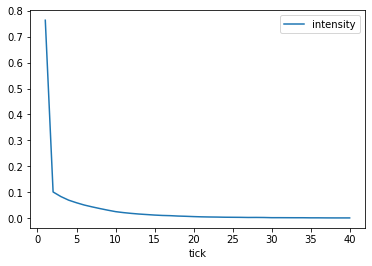

In [189]:
df_bid.plot(x='tick', y=['intensity'])

In [214]:
# estimate k using linear regression
from sklearn.linear_model import LinearRegression
X = df_ask.tick.to_numpy()[:, np.newaxis]
y = np.log(df_ask.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_ask = - reg.coef_[0]
A_ask = np.exp(reg.intercept_)
print('k: ', k_ask)
print('A: ', A_ask)

r:  0.8939027817302241
k:  0.11580620684344611
A:  0.10165680649202904


In [215]:
X = df_bid.tick.to_numpy()[:, np.newaxis]
y = np.log(df_bid.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_bid = - reg.coef_[0]
A_bid = np.exp(reg.intercept_)
print('k: ', k_bid)
print('A: ', A_bid)

r:  0.9065124901679703
k:  0.11605433591682768
A:  0.09895956322824863


In [221]:
k = np.mean([k_bid, k_ask])
A = np.mean([A_bid, A_ask])
print('k mean: ', k)
print('A mean: ', A)

k mean:  0.1159302713801369
A mean:  0.10030818486013884


In [233]:
A*np.exp(-k * np.arange(40.))
df_ask.loc[:, 'estimated'] = A*np.exp(-k * np.arange(40.))

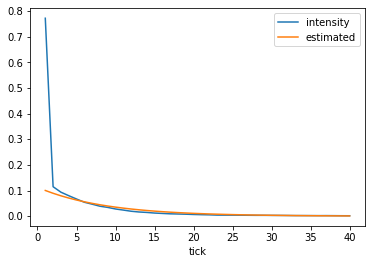

In [234]:
df_ask.plot(x='tick', y=['intensity', 'estimated'])

In this case lower tick intensity are significantly under-estimated

## Parameter estimation: gamma

Gamma is a parameter for market maker's risk aversion factor, there is no easy way which can be detailed in this notebook. It seems this parameter comes from 3 approaches:

- empirical: in lots of literatures this value is 0.1
- machine (reinforcement) learning: see this [repo](https://github.com/im1235/ISAC)

Let me know if you have better findings :D